In [29]:
import Pkg; Pkg.add("Distributions"); Pkg.add("Plots"); Pkg.add("StatsFuns");
using LinearAlgebra, Distributions, Plots, StatsFuns;


# Theory

In [2]:
arr = (t,k) -> [copy(t) for k=1:k]
I_ = m -> Diagonal(ones(m));

**Functions to draw $X$ and $Y$** (rep_n is of size $k$ and gives the number of elements in each class, C is a list of $k$ covariances and m, a list of m means 

In [45]:
function tirage(p,k,rep_n,C,m)
#     provides a list of n matrices of size kp * k, they are the \tilde x_i
    X = zeros(p,0)
    for a = 1:k
        sqcov = (C[a])^(1//2)
        X = [ X  sqcov*randn(p,rep_n[a])+m[a]*ones(1,rep_n[a])]
    end
    return  [kron(I_(k), X[:,i]) for i=1:n]
end
function j(k)
    j = I_(k) + zeros(k,k); 
    return [Int.(j[i,:]) for i=1:k]
end
function label(k,rep_n)
    Y = zeros(Int, k,0);
    for a = 1:k
         Y = [ Y  j(k)[a]*ones(Int,1,rep_n[a])]
    end
    return Y
end;


**Functions to compute the softmax weights** 

In [22]:
σ = x -> softmax(x)
function f(k, a, λ, x)
    return (j(k)[a] -σ(x))/λ[a]
end;
function Ψ(n, W, λ, Xs, Y)
    Ws = arr(W,n)
    return sum([Xs[i]*f(k, cl(i), λ, Xs[i]'*W) for i=1:n])/n
end

# λ must be sufficiently big for the fixed point equation to be contractive
function rob_regr(n,p,k,λ, Xs, Y)
    W = 2*ones(p*k)
    W_aux = ones(p*k)
    while norm(W - W_aux) > 1e-6
        W_aux =copy(W)
        W = Ψ(n,W,λ, Xs, Y)
    end
    return W
end;

**Definition of $\zeta$ and $\xi$**

In [24]:
function df(k, a, λ, x)
    return (-Diagonal(σ(x)[:]) + σ(x)* σ(x)')/λ[a]
end;
function ζ(k, a, λ, Δ, x)
    ζ = ones(k,1)
    ζ_aux = zeros(k,1)
    while norm(ζ - ζ_aux)> 1e-3
        ζ_aux = ζ
        ζ = x + Δ[a] * f(k, a, λ, ζ)
    end
    return ζ
end
function dζ(k, a, λ, Δ, x)
    return inv(I_(k)- Δ[a]*df(k, a, λ, ζ(k, a, λ, Δ, x)))
end
function ξ(k, a, λ, Δ, x)
    return inv(Δ[a])*(ζ(k, a, λ, Δ, x) - x)
end

function dξ(k, a, λ, Δ, x)
    return inv(Δ[a])*(dζ(k, a, λ, Δ, x) - I_(k))
end;

** Function to draw a list of z ** it is used afterwards to compute extimates of $\mathbb E[\xi(z)]$, $\mathbb E[d\xi(z)]$, $\mathbb E[\xi(z)^2]$

In [23]:
function tirage_z(k,C_za, m_za, T)
    return C_za^(1//2)*randn(k,T) + m_za*ones(1,T)
end;

**Tool function** used to compute $\Delta$ and the covariances of $z$

In [46]:
function mat_tr(p,k,Mkp,Mp)
    ind_p = [(1+(p*(i-1))):(p*i) for i=1:k]
    rtn = zeros(k,k)
    for a=1:k, b=1:k
        rtn[a,b] = tr(Mkp[ind_p[a],ind_p[b]]*Mp)
    end
    return rtn
end;

**Central function computing the fixed point** it provides the statistics of $W$

In [47]:
# λ must be sufficiently big for the algorithm to converge
function pt_fixe(n,p,k, λ, rep, C, m, T)
    C_zs = arr(Array(I_(k)),k)
    m_zs = arr(ones(k,1),k)
    C_zs_aux = 2*copy(C_zs)
    m_zs_aux = 2*copy(m_zs)
    C_W = zeros(k*p,k*p)
    m_W = zeros(p*k,1)
    Δ = arr(Array(I_(k)),k)
    while sum(norm.(C_zs_aux -C_zs))+ sum(norm.(m_zs_aux - m_zs))>4e-4
        println("error = $(sum(norm.(C_zs_aux -C_zs)) + sum(norm.(m_zs_aux - m_zs)))")
        C_zs_aux = copy(C_zs)
        m_zs_aux = copy(m_zs)
        E_ξ = arr(zeros(k,1),k)
        E_dξ = arr(zeros(k,k),k)
        E_ξ2 = arr(zeros(k,k),k)
        for l = 1:k
            z = tirage_z(k,C_zs[l],m_zs[l], T)
            E_ξ[l] = sum([ξ(k, l, λ,Δ, z[:,t]) for t=1:T])/T
            E_dξ[l] = sum([dξ(k, l, λ,Δ, z[:,t]) for t=1:T])/T
            E_ξ2[l] = sum([ξ(k, l, λ,Δ, z[:,t])*ξ(k, l, λ,Δ, z[:,t])' for t=1:T])/T
        end
        tμ = sum(rep .* (kron.(E_ξ, m)))    
        tC = sum(rep .* (kron.(E_ξ2, C)))
        K = sum(rep .* (kron.(E_dξ, C)))
        tQ = inv(I_(p*k) - K)
        m_W = tQ * tμ
        Δ = [mat_tr(p,k, tQ, C[l])/n for l=1:k]
        C_W = ones(k*p,k*p)
        C_W_aux = zeros(k*p,k*p)
        while norm(C_W - C_W_aux) > 1e-4
            C_W_aux = copy(C_W)
            C_W = tC/n + K*C_W*K
        end
        m_zs= arr(zeros(k,1),k)
        C_zs = arr(zeros(k,k),k)
        for l=1:k
            m_zs[l] = reshape([(m_W[(1+(p*(a-1))):(p*a)]'*m[l])[1] for a=1:k], k, 1)
            C_zs[l] = mat_tr(p,k, C_W + m_W*m_W', C[l])
            C_zs[l] += 1e-9*I_(k)
#           We add this small variation for C_zs to be nonegative
        end
    end
    return (Δ, m_zs, C_zs, m_W, C_W)
end;

# Practice

## First simple example

**Setting**

In [49]:
n=200; p=300; k=3;
rep = [0.5,0.3,0.2]
round(100*sum(rep)) == 100 || @error "the sum of rep elements must be equal to 1"
rep_n = Int.(floor.(rep *n)); rep_n[k] = n - sum(rep_n[1:(k-1)])
# C = [Diagonal(rand(p)), Diagonal(rand(p))]/10
C = [Diagonal(ones(p)), Diagonal(ones(p)), Diagonal(ones(p))]
# C = [Diagonal(rand(p)), Diagonal(rand(p)), Diagonal(rand(p))]
# m = [randn(p,1)/sqrt(p), randn(p,1)/sqrt(p)]/10
m = [randn(p,1)/sqrt(p), randn(p,1)/sqrt(p), randn(p,1)/sqrt(p)]*2
# m = [ones(p,1)/sqrt(p), randn(p,1)/sqrt(p), randn(p,1)/sqrt(p)]
Xs = tirage(p,k,rep_n,C,m);
Y = label(k,rep_n)
cl = i -> ([1:k...]'*Y)[i]
λ = 20* ones(k)
T = 1000
(Δ, m_zs, C_zs, m_W, C_W) = pt_fixe(n,p,k, λ, rep, C, m, T);

error = 10.392304845413264
error = 10.385711445632838
error = 0.007845252156654456


**Empirical estimation of C_W and m_W**

In [54]:
T = 500
S_W_pr = zeros(k*p,k*p);m_W_pr = zeros(p*k);for t= 1:T
    (t%10 == 0) && print("$t   ")
    Xs = tirage(p, k, rep_n, C, m)
    W = rob_regr(n,p,k,λ, Xs, Y)
    global m_W_pr += W/T
    global S_W_pr+=copy(W*W')/T
end
C_W_pr = S_W_pr - m_W_pr*m_W_pr';

10   20   30   40   50   60   70   80   90   100   110   120   130   140   150   160   170   180   190   200   210   220   230   240   250   260   270   280   290   300   310   320   330   340   350   360   370   380   390   400   410   420   430   440   450   460   470   480   490   500   

In [52]:
[m_W[1:5] m_W_pr[1:5]]

5×2 Array{Float64,2}:
 -0.000604311  -0.000596037
  0.00118633    0.00117049 
 -0.00145357   -0.00139568 
 -0.00118097   -0.00116314 
 -0.00226622   -0.00223742 

In [53]:
[C_W[1:5, 1] C_W_pr[1:5, 1]]

5×2 Array{Float64,2}:
 3.14474e-6    2.95195e-6
 2.05078e-39  -2.04616e-7
 2.05078e-39  -4.68034e-9
 2.05078e-39  -1.12375e-7
 2.05078e-39   9.84857e-8

## Second example with variating parameters

**Tool function** to compute the performances for each class

In [34]:
coord =  i -> (v->v[i])
function classif(label)
    return coord(1).(coord(2).(findmax.(label)))
end
function class_score(classif, k)
    cs = zeros(k)
    for a=1:k
        cs[a] = sum(classif .== a)/length(classif)
    end
    return cs
end;

**Influence of the regularization parameters**

In [44]:
# ns = [20,100,200,350,500]
# lth = length(ns)
α = 4
β = 20
λs = [[β+α*(i-2),β, β+α*(4-i)] for i=1:5]
lth = length(λs)
T =1000
perf_tr_th = arr(zeros(k),lth);perf_tr_pr = arr(zeros(k),lth);perf_tst_pr = arr(zeros(k),lth); perf_tst_th=arr(zeros(k),lth); for i = 1:lth
    λ= λs[i]
    println(λ)
#     n= ns[i]
#     println(n)
    rep_n = floor.(Int,n*rep)
    rep_n[end] = n - sum(rep_n[1:(end-1)])
    ind_n = [(1+sum(rep_n[1:a-1])): sum(rep_n[1:a]) for a=1:k]
    (Δ,m_z, C_z, C_W, m_W) = pt_fixe(n,p,k, λ, rep, C, m, T)
    T=100000
    for l= 1:k
        @info n l Δ[l] m_z[l] C_z[l]
        z = tirage_z(k,C_z[l],m_z[l],T)
        class_tst_th = classif(σ.([z[:,t] for t =1:T]))
        class_tr_th = classif(σ.([ζ(k, l, λ, Δ, z[:,t]) for t =1:T]))
        perf_tst_th[i][l] = class_score(class_tst_th, k)[l]
        perf_tr_th[i][l] = class_score(class_tr_th, k)[l]
    end

    T_pr = 50
    for t = 1:T_pr
        Xs = tirage(p, k, rep_n, C, m)
        Y = label(k,rep_n)
        W = rob_regr(n,p,k,λ, Xs, Y)
        for l=1:k
            rep_n_pr = zeros(Int,k)
            rep_n_pr[l] = n
            X_tsts = tirage(p, k, rep_n_pr, C, m)
            class_tst_pr = classif(σ.([X_tsts[i]'*W for i=1:n]))
            class_tr_pr = classif(σ.([Xs[i]'*W for i in ind_n[l]]))
            perf_tst_pr[i][l] += class_score(class_tst_pr, k)[l]/T_pr
            perf_tr_pr[i][l] += class_score(class_tr_pr, k)[l]/T_pr
        end
    end
end

[12, 20, 28]
error = 10.392304845413264
error = 10.380425907234962
error = 0.01614047574903043
error = 0.0008266781067767385


┌ Info: 200
│   l = 1
│   Δ[l] = [1.47912 0.0105324 0.0103432; 0.0105324 1.48033 0.00914016; 0.0103432 0.00914016 1.48052]
│   m_z[l] = [0.0996452; -0.0507112; -0.048934]
│   C_z[l] = [0.00465636 -0.00256003 -0.00209633; -0.00256003 0.00198366 0.000576368; -0.00209633 0.000576368 0.00151996]
└ @ Main In[44]:19
┌ Info: 200
│   l = 2
│   Δ[l] = [1.47912 0.0105324 0.0103432; 0.0105324 1.48033 0.00914016; 0.0103432 0.00914016 1.48052]
│   m_z[l] = [-0.0199918; 0.037407; -0.0174152]
│   C_z[l] = [0.00465636 -0.00256003 -0.00209633; -0.00256003 0.00198366 0.000576368; -0.00209633 0.000576368 0.00151996]
└ @ Main In[44]:19
┌ Info: 200
│   l = 3
│   Δ[l] = [1.47912 0.0105324 0.0103432; 0.0105324 1.48033 0.00914016; 0.0103432 0.00914016 1.48052]
│   m_z[l] = [-0.00581407; -0.0103811; 0.0161952]
│   C_z[l] = [0.00465636 -0.00256003 -0.00209633; -0.00256003 0.00198366 0.000576368; -0.00209633 0.000576368 0.00151996]
└ @ Main In[44]:19


[16, 20, 24]
error = 10.392304845413264
error = 10.384197512009711
error = 0.010942663270365643


┌ Info: 200
│   l = 1
│   Δ[l] = [1.4822 0.00897627 0.0088201; 0.00897627 1.48283 0.00819495; 0.0088201 0.00819495 1.48298]
│   m_z[l] = [0.0765816; -0.0392395; -0.0373421]
│   C_z[l] = [0.00287238 -0.00163164 -0.00124074; -0.00163164 0.0015493 8.23379e-5; -0.00124074 8.23379e-5 0.00115841]
└ @ Main In[44]:19
┌ Info: 200
│   l = 2
│   Δ[l] = [1.4822 0.00897627 0.0088201; 0.00897627 1.48283 0.00819495; 0.0088201 0.00819495 1.48298]
│   m_z[l] = [-0.0196463; 0.0372741; -0.0176278]
│   C_z[l] = [0.00287238 -0.00163164 -0.00124074; -0.00163164 0.0015493 8.23379e-5; -0.00124074 8.23379e-5 0.00115841]
└ @ Main In[44]:19
┌ Info: 200
│   l = 3
│   Δ[l] = [1.4822 0.00897627 0.0088201; 0.00897627 1.48283 0.00819495; 0.0088201 0.00819495 1.48298]
│   m_z[l] = [-0.00806519; -0.0114547; 0.0195199]
│   C_z[l] = [0.00287238 -0.00163164 -0.00124074; -0.00163164 0.0015493 8.23379e-5; -0.00124074 8.23379e-5 0.00115841]
└ @ Main In[44]:19


[20, 20, 20]
error = 10.392304845413264
error = 10.385736763308742
error = 0.008540996954869881


┌ Info: 200
│   l = 1
│   Δ[l] = [1.48379 0.00816004 0.00804999; 0.00816004 1.48411 0.00772676; 0.00804999 0.00772676 1.48422]
│   m_z[l] = [0.0621685; -0.0321404; -0.030028]
│   C_z[l] = [0.00202416 -0.00115424 -0.000869918; -0.00115424 0.00136238 -0.000208137; -0.000869918 -0.000208137 0.00107806]
└ @ Main In[44]:19
┌ Info: 200
│   l = 2
│   Δ[l] = [1.48379 0.00816004 0.00804999; 0.00816004 1.48411 0.00772676; 0.00804999 0.00772676 1.48422]
│   m_z[l] = [-0.0194644; 0.0371981; -0.0177337]
│   C_z[l] = [0.00202416 -0.00115424 -0.000869918; -0.00115424 0.00136238 -0.000208137; -0.000869918 -0.000208137 0.00107806]
└ @ Main In[44]:19
┌ Info: 200
│   l = 3
│   Δ[l] = [1.48379 0.00816004 0.00804999; 0.00816004 1.48411 0.00772676; 0.00804999 0.00772676 1.48422]
│   m_z[l] = [-0.0105649; -0.0132456; 0.0238105]
│   C_z[l] = [0.00202416 -0.00115424 -0.000869918; -0.00115424 0.00136238 -0.000208137; -0.000869918 -0.000208137 0.00107806]
└ @ Main In[44]:19


[24, 20, 16]
error = 10.392304845413264
error = 10.386145682952549
error = 0.007472947992390596


┌ Info: 200
│   l = 1
│   Δ[l] = [1.48445 0.00778902 0.00776353; 0.00778902 1.4846 0.00761153; 0.00776353 0.00761153 1.48462]
│   m_z[l] = [0.0522148; -0.0273169; -0.0248979]
│   C_z[l] = [0.00158632 -0.000841122 -0.000745197; -0.000841122 0.00129875 -0.000457625; -0.000745197 -0.000457625 0.00120282]
└ @ Main In[44]:19
┌ Info: 200
│   l = 2
│   Δ[l] = [1.48445 0.00778902 0.00776353; 0.00778902 1.4846 0.00761153; 0.00776353 0.00761153 1.48462]
│   m_z[l] = [-0.0193346; 0.0371145; -0.0177798]
│   C_z[l] = [0.00158632 -0.000841122 -0.000745197; -0.000841122 0.00129875 -0.000457625; -0.000745197 -0.000457625 0.00120282]
└ @ Main In[44]:19
┌ Info: 200
│   l = 3
│   Δ[l] = [1.48445 0.00778902 0.00776353; 0.00778902 1.4846 0.00761153; 0.00776353 0.00761153 1.48462]
│   m_z[l] = [-0.0138779; -0.0160561; 0.0299339]
│   C_z[l] = [0.00158632 -0.000841122 -0.000745197; -0.000841122 0.00129875 -0.000457625; -0.000745197 -0.000457625 0.00120282]
└ @ Main In[44]:19


[28, 20, 12]
error = 10.392304845413264
error = 10.385397215326343
error = 0.007778873918704674


┌ Info: 200
│   l = 1
│   Δ[l] = [1.48425 0.00779909 0.00794661; 0.00779909 1.4843 0.00790198; 0.00794661 0.00790198 1.48415]
│   m_z[l] = [0.0448615; -0.023885; -0.0209766]
│   C_z[l] = [0.00140457 -0.000556239 -0.000848331; -0.000556239 0.0013502 -0.000793962; -0.000848331 -0.000793962 0.00164229]
└ @ Main In[44]:19
┌ Info: 200
│   l = 2
│   Δ[l] = [1.48425 0.00779909 0.00794661; 0.00779909 1.4843 0.00790198; 0.00794661 0.00790198 1.48415]
│   m_z[l] = [-0.0192493; 0.0370145; -0.0177652]
│   C_z[l] = [0.00140457 -0.000556239 -0.000848331; -0.000556239 0.0013502 -0.000793962; -0.000848331 -0.000793962 0.00164229]
└ @ Main In[44]:19
┌ Info: 200
│   l = 3
│   Δ[l] = [1.48425 0.00779909 0.00794661; 0.00779909 1.4843 0.00790198; 0.00794661 0.00790198 1.48415]
│   m_z[l] = [-0.0189427; -0.020762; 0.0397047]
│   C_z[l] = [0.00140457 -0.000556239 -0.000848331; -0.000556239 0.0013502 -0.000793962; -0.000848331 -0.000793962 0.00164229]
└ @ Main In[44]:19


**Plots**

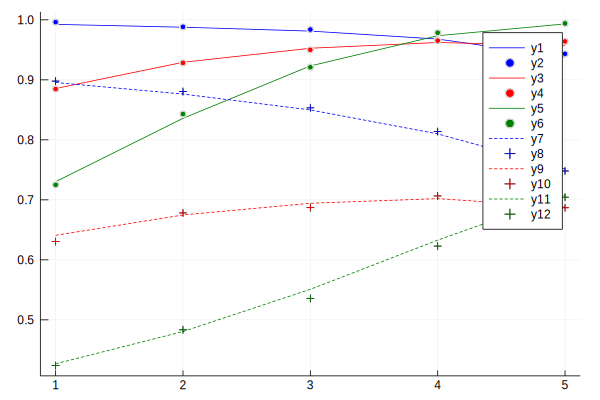

In [55]:
plot(1:5, coord(1).(perf_tr_th),color = :blue)
plot!(1:5, coord(1).(perf_tr_pr), seriestype = :scatter, color = :blue)
plot!(1:5, coord(2).(perf_tr_th), color = :red)
plot!(1:5, coord(2).(perf_tr_pr), seriestype = :scatter, color = :red)
plot!(1:5, coord(3).(perf_tr_th), color = :green)
plot!(1:5, coord(3).(perf_tr_pr), seriestype = :scatter, color = :green)
plot!(1:5, coord(1).(perf_tst_th), linestyle=:dash, color = :blue)
plot!(1:5, coord(1).(perf_tst_pr), seriestype = :scatter, markershape=:cross, color = :blue)
plot!(1:5, coord(2).(perf_tst_th),linestyle=:dash, color = :red)
plot!(1:5, coord(2).(perf_tst_pr), seriestype = :scatter, markershape=:cross, color = :red)
plot!(1:5, coord(3).(perf_tst_th),linestyle=:dash, color = :green)
plot!(1:5, coord(3).(perf_tst_pr), seriestype = :scatter, markershape=:cross, color = :green)